In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

from data_generator import dgen,pack_by_value,downscale_nsave
from dict2obj import Dict2Obj
from fit_pca import plot_images_table



In [39]:
path = "img/all_small_2409"
experiment = Dict2Obj({
    "start_time":time.mktime((2018,9,24,19,39,4,0,0,0)),
    "tick":10,
    "transition_dur":4,
})
data = list(dgen(path,experiment,start=0,limit = 200))
imgs = [d[0] for d in data]


Returned 104, skipped 96 files


In [40]:

def splitter(data,parts=6):
    for img in data:
        w,h = img.width,img.height
        dw,dh = w//parts, h//parts
        data= np.array(img)
        for idx in range(parts**2):
            x,y = idx%parts,idx//parts
            yield data[y*dh:(y+1)*dh,x*dw:(x+1)*dw]
def resizer(images,factor=0.5):
    for i in images:
        w,h = i.width,i.height
        yield i.resize((int(w*factor),int(h*factor)), Image.ANTIALIAS)
            
patches = list(splitter(resizer(imgs),parts=8))
print(len(patches))


6656


(12, 16, 3)
256


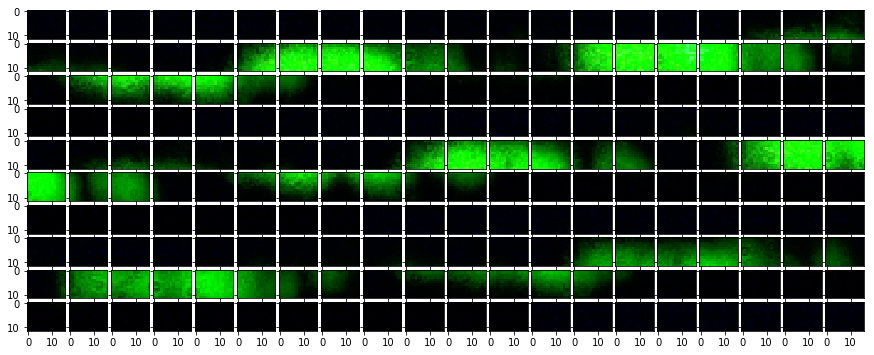

In [58]:
print(patches[0].shape)
patch_shape = patches[0].shape
print(imgs[0].width)
plot_images_table(patches[:200],columns=20,figsize=(15,35))

In [41]:

X = np.array([i[:,:,1].flatten() for i in patches])
print(X.shape)

(6656, 192)


In [131]:
%%time
def pca(X,num_components):
    X=np.array([l-np.mean(l) for l in X]) # Вычитаем среднее
    U,s,V=np.linalg.svd(X)                # Находим собственные вектора
    eps=np.sort(s)[-num_components]       # пороговое собственное значение (служебная строчка) 
    E = np.array([vec for val,vec in zip(s,V)
                  if val>eps])            # берем только важные вектора   (с большими собственными значениями)
    X_=np.dot(E,X.T).T                    # Преобразуем данные
    return X_,E,s
X_,E,s = pca(X,24)

CPU times: user 36.4 s, sys: 4.11 s, total: 40.5 s
Wall time: 13.3 s


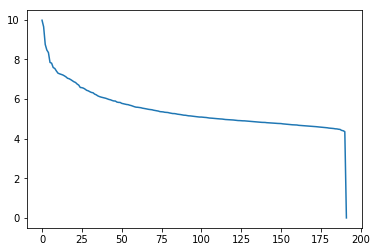

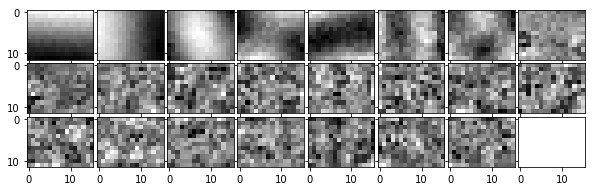

In [132]:
plt.plot(np.log(s+1))
plt.show()
vecs = []
for vec in E:
    img = vec.reshape(*patch_shape[:-1])
    vecs.append(img)
plot_images_table(vecs)

(6656, 14) (14, 192)
True
(96, 128)


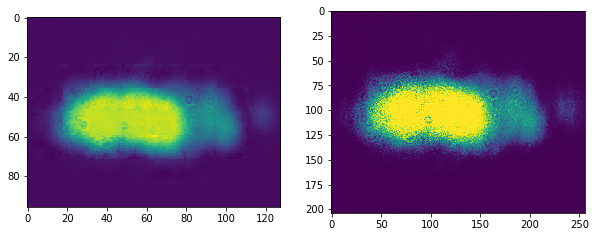

In [127]:
print(X_.shape,E.shape)
print(np.all(np.array([i.shape for i in patches])==(12,16,3)))
restored = np.dot(X_,E).reshape(-1,*patch_shape[:-1])
restored+=np.array([np.mean(l) for l in X]).reshape(-1,1,1)

def merger(patches,parts=6):
    idx = 0
    image=None
    for p in patches:
        if idx>=parts**2:
            idx = 0
            yield image
        if idx==0:
            image = np.zeros((p.shape[0]*parts,p.shape[1]*parts))
            dh,dw = p.shape
        x,y = idx%parts,idx//parts
        image[y*dh:(y+1)*dh,x*dw:(x+1)*dw]=p
        idx+=1

f,ax = plt.subplots(1,2,figsize=(10,5))
merged = list(merger(restored,parts=8))
print(merged[0].shape)
ax[0].imshow(merged[0])
ax[1].imshow(np.array(imgs[0])[:,:,1])

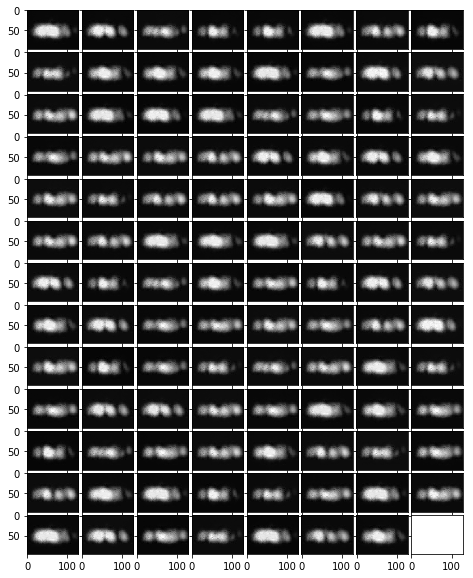

In [128]:
plot_images_table(merged[:108])

192.0